In [22]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image we will be working on in this homework.

(<Axes: >, <matplotlib.image.AxesImage at 0x1cde49f6c90>)

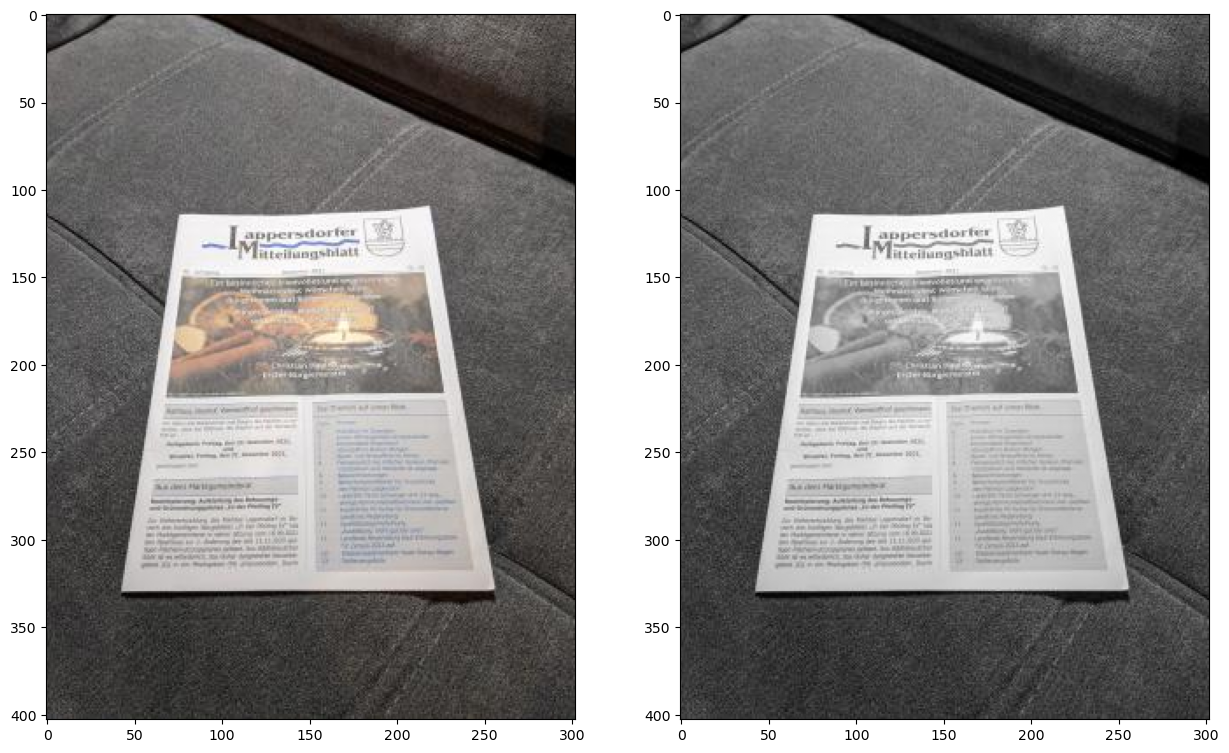

In [23]:
# Let's read the image
img = cv2.imread('document.jpg')
# Convert it to gray scale
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

### Harris Corner Detector
Let us now compute Harris corners. Remember that the Harris detector computes the "cornerness" score for each image pixel.

In [24]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04
cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# We are not interested in edges, so put to zero all negative cornerness values
cornerness[cornerness < 0] = 0

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

(<Axes: >, <matplotlib.image.AxesImage at 0x1cde2bbf110>)

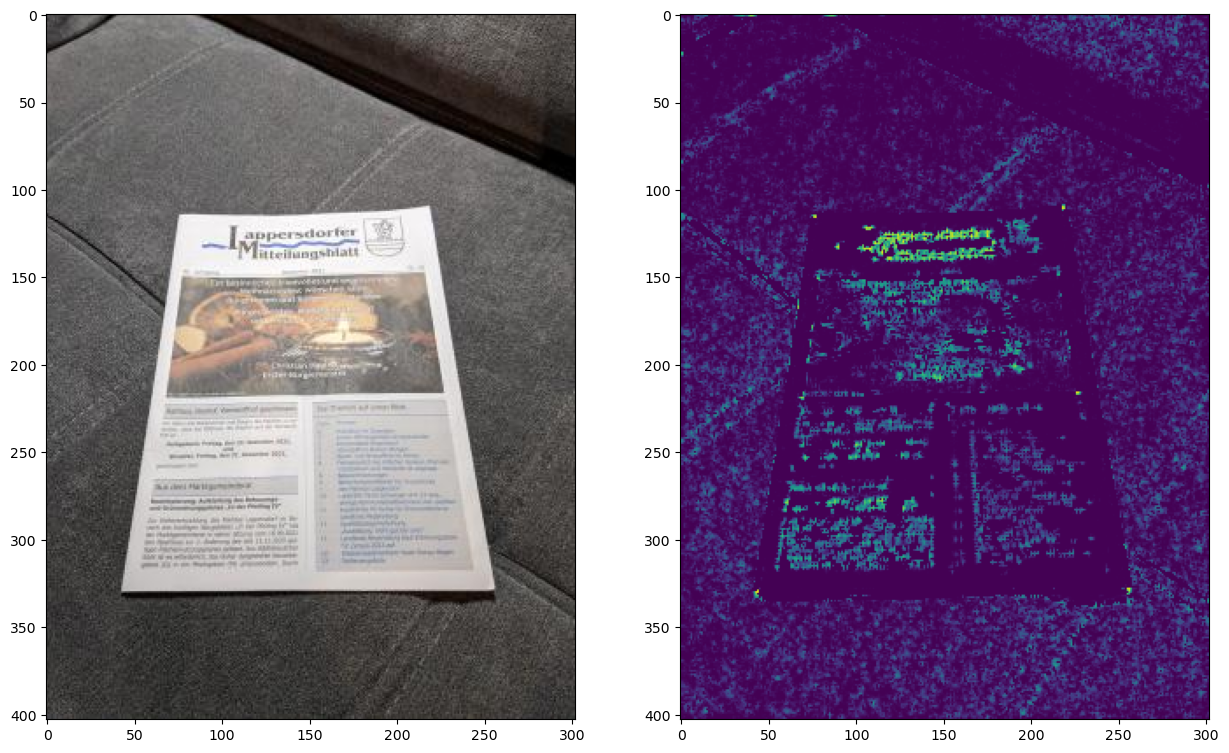

In [25]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

At this point, you can see that the Harris detector has detected a lot of features. Not only the four document corners, but also the corners corresponding to (black) letters printed on (white) paper. How can we filter out everything but the 4 document corners?

For that purpose, let's design a custom feature descriptor suitable to detect the document corners. In order to do so, let's have a look at the top left corner.



A good descriptor of that corner, given a certain neghbouring region, would be to assess that the bottom-right quadrant is (much) brighter than the other three quadrants (i.e. top-left, top-right, bottom-left). Let's then implement it :-) I'll do the implementation for the top-left corner, you shall do the rest.

(<Axes: >, <matplotlib.image.AxesImage at 0x1cde4ee4910>)

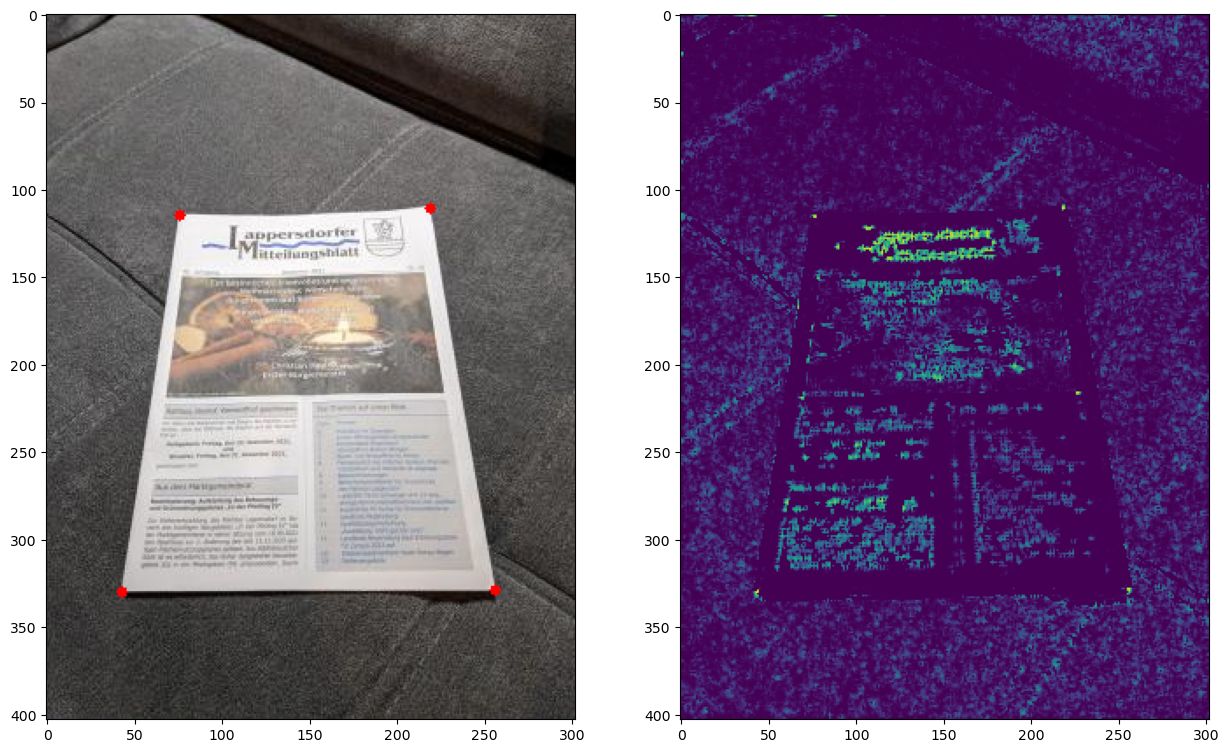

In [26]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_ritgh = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size:2*quad_size+1]
        quad_bottom_left = block[quad_size:2*quad_size+1, 0:quad_size]
        quad_bottom_right = block[quad_size:2*quad_size+1, quad_size:2*quad_size+1]
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)
            
        # Top-right corner
        # For the top-right document corner, the bottom-left quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_left) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
        # Let's detect the best descriptor
        if descriptor > th_top_right:
            # We update the threshold
            th_top_right = descriptor
            # And we update the optimal location
            opt_top_right = (c, r)
            
        # Bottom-left corner
        # For the Bottom-left document corner, the top-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_top_right) - \
                     np.mean(quad_top_left) - np.mean(quad_bottom_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_bottom_left:
            # We update the threshold
            th_bottom_left = descriptor
            # And we update the optimal location
            opt_bottom_left = (c, r)
            
        # Bottom-right corner
        # For the Bottom-right document corner, the top-left quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_top_left) - \
                     np.mean(quad_bottom_right) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_bottom_right:
            # We update the threshold
            th_bottom_right = descriptor
            # And we update the optimal location
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)

### Questions
* Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How?
* Yes, camera resolution signifantly affects the output of the Harris Corner Detector since more resolution gives more details. Having more details more corners could be detected. It leads to potentially better results and more accurate localization of those corners however it takes more efforts to detect significant сorners and filter out unnecessary/"noisy" ones.
*    
* If we increased the resolution of the camera, what would you change in the current algorithm?
* 1. I would increase blockSize since a higher-resolution image contains more pixels and a corner could be situated in a larger area.
  2. Secondly, I would increase kernel size (the same reason as in the first point).
  3. Also I think sensivity parameter (k) should be rethought since we would have more "fake"/unmeaningful corners in the output of Harris Corner detector (better resolution image has more details) and may be our algorithm has to be more selective regarding choosing the most meaningful corners.
  4. And lastly, I could play around with the threshold in order to filter unmeaningful corners as well.

Remember, I am **not** looking for a particular answer. I want to see how you think, so be creative ;-)